#### Name:  Sundipta Rao
#### Date: 5/7/16

## Lander-Waterman Statistics 
### Plot fraction of the genome covered as a function of coverage depth.

In [1]:
import pybedtools
import matplotlib
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
a = pybedtools.BedTool('./ec.sorted.bam') #usingsorted bam file generated from the last homework
b = a.genome_coverage(g='./ec.genome') #using a genome file with tab-seperated name and length of the e.coli genome


In [3]:
b.head(3)

NC_000913	0	27936	4639675	0.00602111
 NC_000913	1	2552	4639675	0.000550039
 NC_000913	2	1849	4639675	0.000398519
 

In [4]:
c = b.to_dataframe()
c.columns = ['chrom','bases','depth','name','score'] #renaming columns

In [5]:
c.head(4)

,chrom,bases,depth,name,score
0,NC_000913,0,27936,4639675,0.006021
1,NC_000913,1,2552,4639675,0.000550
2,NC_000913,2,1849,4639675,0.000399
3,NC_000913,3,2749,4639675,0.000592


In [6]:
d = c.loc[c['chrom'] == 'genome'] #choosing only the subset of the data labeled "genome"

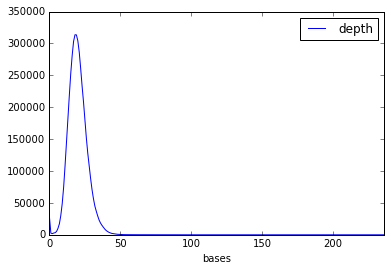

In [7]:
d.plot("bases","depth")

## Repeat statistics of genomes 
### Compute the triple repeat and interleaved statistics of the E. coli genome 

In [8]:
## Use Mummer to get statistics on the number of repeats greater than or equal to 200 bases on the forward strand only 
! repeat-match -f -n 200 ~/venv2/E.coli_K12_ATCC_700926.fasta > seq.repeats

Genome Length = 4639675   Used 2977580 internal nodes


In [34]:
# Read the data from MuMmer in
repeats = pd.read_csv('~/venv2/seq.repeats', delimiter=r"\s+", skiprows=1)
repeats.head(3)

,Start1,Start2,Length
0,1568892,3664426,479
1,3184118,4496204,1331
2,380484,4496204,1331


In [10]:
# Sort the data by length of the repeat
new = repeats.sort_values(by = 'Length')
new.head(10)

,Start1,Start2,Length
42,270608,1468163,202
112,4293858,4294084,207
35,223761,4033544,213
34,4033544,4206160,213
56,2302595,2302821,214
57,731827,733698,224
48,2729102,3426707,224
144,3939685,4206024,224
111,226075,4035858,225
88,1268316,1269386,228


In [11]:
# rearrange the columns so Length is first (not necessary, but it's pretty)
cols = new.columns.tolist()
#cols
cols = cols[-1:] + cols[:-1]
#cols
new = new[cols]
new.head(5)

,Length,Start1,Start2
42,202,270608,1468163
112,207,4293858,4294084
35,213,223761,4033544
34,213,4033544,4206160
56,214,2302595,2302821


In [12]:
# get the number of triple repeats
mylist = []

#create a data structure with the length associated with the starts 
for index, row in new.iterrows() :
    new_set = set([row['Start1'],row['Start2']])
    mylist.append([row['Length'], new_set])
    #print mylist

merged_repeats = []
#merge the starts that are listed more than once with the same length
for repeat_set in mylist:
    for merged_repeat in merged_repeats:
        if merged_repeat[0] == repeat_set[0]:
            if merged_repeat[1] & repeat_set[1]:
                merged_repeat[1] |= repeat_set[1]
                break
    else:
        merged_repeats.append(repeat_set)
#print merged_repeats  

In [13]:
len(merged_repeats)

96

In [14]:
reps = 0
i = 0
for repeat in merged_repeats:
    #print len(merged_repeats[i])
    if len(repeat[1])>2:
        reps = reps + 1

In [15]:
reps # number of repeats with greater than or equal to 3 repeats

27

In [16]:
triples = 0
i = 0
for repeat in merged_repeats:
    #print len(merged_repeats[i])
    if len(repeat[1])== 3:
        triples = triples + 1
triples #number of triple repeats

13

#### There are 13 exact triple repeats and 27 repeats that have 3 or more repeats.

In [17]:
#determining the number of interleaved repeats
def interleaved(current_row, temp): #function that tells you if things are interleaved or not
    if (temp[0] <= current_row[0] and temp[1] <= current_row[1] and temp[1] >= current_row[0]): 
        return True
    elif (temp[0] >= current_row[0] and temp[0] <= current_row[1] and temp[1] >= current_row[1]):
        return True
    else:
        return False
interleaves = 0
listed_data = list([[row['Start1'], row['Start2']] for index, row in new.iterrows()])
while listed_data: #loop compares one entry to the others and counts if they are interleaved
    current_row = listed_data.pop()
    for i in listed_data:
        temp = [row['Start1'],row['Start2']]
        if interleaved(current_row,temp):
            interleaves = interleaves + 1
                                                                     

In [18]:
print interleaves

1946


#### This means that the 162 repeats given by MuMmer have 1946 different combinations of interleaved repeats. 

## de Bruijn graph assembly 
### Implement the de Bruijn graph algorithm for assembly. 


In [19]:
class DeBruijnGraph:
    ''' De Bruijn directed multigraph built from a collection of
        strings. User supplies strings and k-mer length k.  Nodes
        are k-1-mers.  An Edge corresponds to the k-mer that joins
        a left k-1-mer to a right k-1-mer. '''
 
    @staticmethod
    def chop(st, k):
        ''' Chop string into k-mers of given length '''
        for i in xrange(0, len(st)-(k-1)):
            yield (st[i:i+k], st[i:i+k-1], st[i+1:i+k])
    
    class Node:
        ''' Node representing a k-1 mer.  Keep track of # of
            incoming/outgoing edges so it's easy to check for
            balanced, semi-balanced. '''
        
        def __init__(self, km1mer):
            self.km1mer = km1mer
            self.nin = 0
            self.nout = 0
        
        def isSemiBalanced(self):
            return abs(self.nin - self.nout) == 1
        
        def isBalanced(self):
            return self.nin == self.nout
        
        def __hash__(self):
            return hash(self.km1mer)
        
        def __str__(self):
            return self.km1mer
    
    def __init__(self, strIter, k, circularize=False):
        ''' Build de Bruijn multigraph given string iterator and k-mer
            length k '''
        self.G = {}     # multimap from nodes to neighbors
        self.nodes = {} # maps k-1-mers to Node objects
        for st in strIter:
            if circularize:
                st += st[:k-1]
            for kmer, km1L, km1R in self.chop(st, k):
                nodeL, nodeR = None, None
                if km1L in self.nodes:
                    nodeL = self.nodes[km1L]
                else:
                    nodeL = self.nodes[km1L] = self.Node(km1L)
                if km1R in self.nodes:
                    nodeR = self.nodes[km1R]
                else:
                    nodeR = self.nodes[km1R] = self.Node(km1R)
                nodeL.nout += 1
                nodeR.nin += 1
                self.G.setdefault(nodeL, []).append(nodeR)
        # Iterate over nodes; tally # balanced, semi-balanced, neither
        self.nsemi, self.nbal, self.nneither = 0, 0, 0
        # Keep track of head and tail nodes in the case of a graph with
        # Eularian walk (not cycle)
        self.head, self.tail = None, None
        for node in self.nodes.itervalues():
            if node.isBalanced():
                self.nbal += 1
            elif node.isSemiBalanced():
                if node.nin == node.nout + 1:
                    self.tail = node
                if node.nin == node.nout - 1:
                    self.head = node
                self.nsemi += 1
            else:
                self.nneither += 1
    
    def nnodes(self):
        ''' Return # nodes '''
        return len(self.nodes)
    
    def nedges(self):
        ''' Return # edges '''
        return len(self.G)
    
    def hasEulerianWalk(self):
        ''' Return true iff graph has Eulerian walk. '''
        return self.nneither == 0 and self.nsemi == 2
    
    def hasEulerianCycle(self):
        ''' Return true iff graph has Eulerian cycle. '''
        return self.nneither == 0 and self.nsemi == 0
    
    def isEulerian(self):
        ''' Return true iff graph has Eulerian walk or cycle '''
        # technically, if it has an Eulerian walk
        return self.hasEulerianWalk() or self.hasEulerianCycle()
    
    def eulerianWalkOrCycle(self):
        ''' Find and return sequence of nodes (represented by
            their k-1-mer labels) corresponding to Eulerian walk
            or cycle '''
        assert self.isEulerian()
        g = self.G
        if self.hasEulerianWalk():
            g = g.copy()
            g.setdefault(self.tail, []).append(self.head)
        # graph g has an Eulerian cycle
        tour = []
        src = g.iterkeys().next() # pick arbitrary starting node
        
        def __visit(n):
            while len(g[n]) > 0:
                dst = g[n].pop()
                __visit(dst)
            tour.append(n)
        
        __visit(src)
        tour = tour[::-1][:-1] # reverse and then take all but last node
            
        if self.hasEulerianWalk():
            # Adjust node list so that it starts at head and ends at tail
            sti = tour.index(self.head)
            tour = tour[sti:] + tour[:sti]
        
        # Return node list
        return map(str, tour)

In [20]:
class DeBruijnGraph2(DeBruijnGraph):
    def to_dot(self, weights=False):
        """ Return string with graphviz representation.  If 'weights'
            is true, label edges corresponding to distinct k-1-mers
            with weights, instead of drawing separate edges for
            k-1-mer copies. """
        dot_str = ["digraph \"DeBruijn graph\" {\n",
                   "  bgcolor=\"transparent\";\n"]
        for node in self.G.iterkeys():
            lab = node.km1mer
            dot_str.append("  %s [label=\"%s\"] ;\n" % (lab, lab))
        for src, dsts in self.G.iteritems():
            srclab = src.km1mer
            if weights:
                weightmap = {}
                if weights:
                    for dst in dsts:
                        weightmap[dst] = weightmap.get(dst, 0) + 1
                for dst, v in weightmap.iteritems():
                    dstlab = dst.km1mer
                    dot_str.append("  %s -> %s [label=\"%d\"] ;\n" % (srclab, dstlab, v))
            else:
                for dst in dsts:
                    srclab, dstlab = src.km1mer, dst.km1mer
                    dot_str.append("  %s -> %s [label=\"\"] ;\n" % (srclab, dstlab))
        dot_str.append("}\n")
        return ''.join(dot_str)

In [101]:
# %install_ext https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py

Installed gvmagic.py. To use it, type:
  %load_ext gvmagic


/Users/Sundipta/venv2/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


In [21]:
%load_ext gvmagic

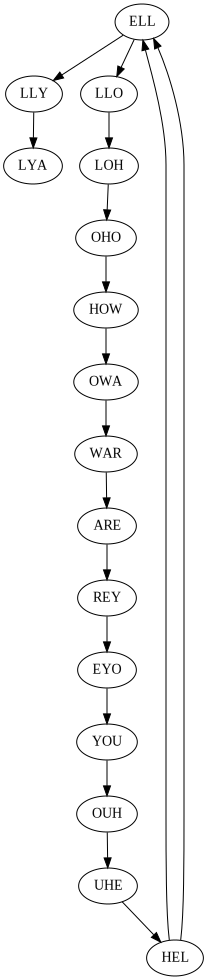

In [22]:
%dotobj DeBruijnGraph2(['HELLOHOWAREYOUHELLYA'], 4)

### assembly of TAAAAACCCCAAAAAG from its 5-mer spectrum

In [23]:
walk = DeBruijnGraph(['TAAAAACCCCAAAAAG'], k=5)

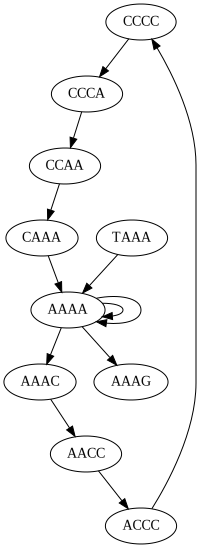

In [24]:
%dotobj DeBruijnGraph2(['TAAAAACCCCAAAAAG'], k=5)

In [105]:
walk.isEulerian(), walk.hasEulerianWalk(), walk.hasEulerianCycle()

(True, True, False)

#### This graph has an Eulerian path, but it is not unique. There are three paths that you can take along the graph, meaning there are three different assemblies that might occur. 

In [107]:
walk = DeBruijnGraph(['TAAAAACCCCAAAAAG'], k=5).eulerianWalkOrCycle()
walk[0] + ''.join(map(lambda x: x[-1], walk[1:]))

'TAAAAACCCCAAAAAG'

### Assembly of TAAAAACCCCAAAAAG from the support of its 5-mer spectrum

With the support of the 5-mer spectrum, we expect to see subset of the graph above. Since we can't see repeat k-mers in the graph (all non-zero k-mers are set to 1), we will have the option of seeing two sequences, either ('TAAAAACCCCAAAA','AAAAG') or ('TAAAA', 'AAAACCCCAAAAAG'). 


### Generate a random 100 length genome. Generate random 10 length reads from this up to a coverage depth of 30, and give the assembly. Generate random length 10 length reads with 5% error rates and repeat the process. 

In [26]:
import random
# Make a function to make a random genome
def get_random_string(length=100, allowed_chars='ATCG'):
    return ''.join(random.choice(allowed_chars) for i in range(length))

In [27]:
genome = get_random_string(length=100, allowed_chars='ATCG')
genome

'GTGATCAGGCCCCCTAACAGCGTTCACATTCCTCTCACGGGTATAAACCATGGAAGGGCGGTTCAATGTACAACGCGCTGACATACGGGAGGTCTGAGAA'

In [28]:
# Calculate the number of reads based on the definition of coverage ( c = NL/G) 
c = 30
L = 10
G = 100
N = c * G/L
N


300

In [39]:
# Generate a list of N random reads
def chop(st, k):
    ''' Chop string into k-mers of given length '''
    for i in xrange(0, len(st)-(k-1)):
        yield [st[i:i+k], st[i:i+k-1], st[i+1:i+k]]
ten_mers = list(chop(genome,10))
#ten_mers
r = 0
reads = []
while r <300:
    new = random.choice(ten_mers)
    reads.append(new)
    r = r + 1
reads[:20]

[['TCCTCTCACG', 'TCCTCTCAC', 'CCTCTCACG'],
 ['TTCAATGTAC', 'TTCAATGTA', 'TCAATGTAC'],
 ['CCCCCTAACA', 'CCCCCTAAC', 'CCCCTAACA'],
 ['CCCCTAACAG', 'CCCCTAACA', 'CCCTAACAG'],
 ['CAGCGTTCAC', 'CAGCGTTCA', 'AGCGTTCAC'],
 ['TCAATGTACA', 'TCAATGTAC', 'CAATGTACA'],
 ['TTCACATTCC', 'TTCACATTC', 'TCACATTCC'],
 ['GGGAGGTCTG', 'GGGAGGTCT', 'GGAGGTCTG'],
 ['GGAAGGGCGG', 'GGAAGGGCG', 'GAAGGGCGG'],
 ['GTATAAACCA', 'GTATAAACC', 'TATAAACCA'],
 ['GGGCGGTTCA', 'GGGCGGTTC', 'GGCGGTTCA'],
 ['ACGGGAGGTC', 'ACGGGAGGT', 'CGGGAGGTC'],
 ['GCCCCCTAAC', 'GCCCCCTAA', 'CCCCCTAAC'],
 ['AAGGGCGGTT', 'AAGGGCGGT', 'AGGGCGGTT'],
 ['ACCATGGAAG', 'ACCATGGAA', 'CCATGGAAG'],
 ['CGCTGACATA', 'CGCTGACAT', 'GCTGACATA'],
 ['CGGGTATAAA', 'CGGGTATAA', 'GGGTATAAA'],
 ['AGCGTTCACA', 'AGCGTTCAC', 'GCGTTCACA'],
 ['CCTCTCACGG', 'CCTCTCACG', 'CTCTCACGG'],
 ['TTCACATTCC', 'TTCACATTC', 'TCACATTCC']]

In [31]:
# Assemble from reads using modified de Bruijn graph code
def de_bruijn_ize(read_list):
    """ Return a list holding, for each k-mer, its left
        k-1-mer and its right k-1-mer in a pair """
    edges = []
    nodes = set()
    for i in read_list:
        if i[0] not in edges:
            edges.append(i[0])
        if i[1] not in nodes:
            nodes.add(i[1])
        if i[2] not in nodes:
            nodes.add(i[2])
    return nodes, edges

In [32]:
nodes,edges = de_bruijn_ize(reads)

In [ ]:
# Adding a 5% substitution error (because it seems to be the most common error)
error_reads = []
e = 0
while e <= 300:
    s = list(reads[e])
    error_reads.append(s(0))
    #print s
    if e%20 == 0 : 
        s.index('A') #Find the first A in every 20 reads and then change it to a C
    e = e + 1 

In [ ]:
error_nodes,error_edges = de_bruijn_ize(error_reads)

Both sets of reads should assemble correctly. However, the assembly with the high error rate is more difficult because you need to do error correction on the reads before creating a de Bruijn graph and finding the Eulerian path. To do error correction, you first need to get a count of all the k-mers in the reads and then you need to threshold to only take into consideration k-mers with more than the threshold count. Since reads in this case are uniformly distributed and errors happen infrequently enough, a low k-mer count means that it is very likely that an error has occured (as long as you pick k large enough). After getting rid of the erroneous reads, you can continue on to create your graph and EC. 

## Alignment 
### Give an algorithm (described by pseudo code) to find the best alignment of a read onto a DNA sequence and to compute the edit distance for the best alignment.


- Extract substrings of length k from the DNA sequence you are aligning onto. 
- Store them into some sort of a map data structure along with the index at which they occur. 
- Chop the read into k-mers. 
- Pick a k-mer (may be easiest to pick the leftmost k-mer) of the read and search to see if it matches any k-length sequence in the DNA within some edit distance. 
- If it aligns in the DNA, store the edit distance then look at the next k-mer in the read to see if it aligns with the next indexed k-length substring of the DNA. Add to the edit distance. 
- Keep extending the read and adding to the edit distance until you have matched the whole read to the DNA. 

 

### Algorithm (described by pseudo code) to find the best head-to-tail alignment between two reads s and t. The score of a particular alignment between s[i :] and t[: j] is given by max(i, j)− d(s[i :], t[: j]) where d is the edit distance. We need to find the alignment between i and j.

The best alignment algorithm is given by dynamic programming. Say we are comparing two DNA sequences, S and T, where S is length m and T is length n. We need to create a scoring matrix  of size (m+1) by (n+1) and indexed by (i,j), where i is the prefix length of S and j is the prefix length of T.

Psuedo code for comparison of S and T:
 -  Initialize the first column and the first row (m+1)by (n+1) matrix by comparing prefixes. 
     - Identical characters receive a +1, mismatches get a -1, gaps give -2 (inserting or deleting a base
 - Compute the value for the (i,j) entry by looking at the three previous entries (i-1,j-1),(i-1,1), (i, j-1)
     - Pick the maximum schore of either adding a deletion, inserting a base, or rearraning/matching the transcript to get the optimal edit distance
 - Traverse the matrix such that you get the maximum score - this will give you the best alignment. 
 
You can output this score to get an instatiation of the edit distance. 